## TITLE: Find Island

**Purpose:** 

**Dependencies:** 

---


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from clawpack.geoclaw import topotools, dtopotools, marching_front
import os
from clawpack.visclaw import colormaps, plottools
from clawpack.amrclaw import region_tools


In [3]:
topo_file = os.path.join('/home/catherinej/bathymetry/moriches.nc')

In [4]:
topo = topotools.read_netcdf(topo_file)

In [5]:
zmin = -60.
zmax = 40.

land_cmap = colormaps.make_colormap({ 0.0:[0.1,0.4,0.0],
                                     0.25:[0.0,1.0,0.0],
                                      0.5:[0.8,1.0,0.5],
                                      1.0:[0.8,0.5,0.2]})

sea_cmap = colormaps.make_colormap({ 0.0:[0,0,1], 1.:[.8,.8,1]})

cmap, norm = colormaps.add_colormaps((land_cmap, sea_cmap),
                                     data_limits=(zmin,zmax),
                                     data_break=0.)
                                     
sea_cmap_dry = colormaps.make_colormap({ 0.0:[1.0,0.7,0.7], 1.:[1.0,0.7,0.7]})
cmap_dry, norm_dry = colormaps.add_colormaps((land_cmap, sea_cmap_dry),
                                     data_limits=(zmin,zmax),
                                     data_break=0.)

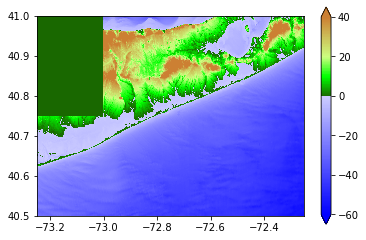

In [6]:
plottools.pcolorcells(topo.X, topo.Y, topo.Z, cmap=cmap, norm=norm)
plt.colorbar(extend='both')
plt.gca().set_aspect(1./np.cos(48*np.pi/180))

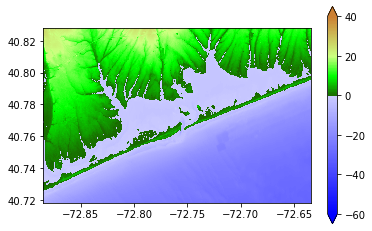

In [7]:
fr = [-72.885652,-72.634247,40.718299,40.828344]
# topo2 = topo.crop(fr)
topo_data = topo.crop(fr)
plottools.pcolorcells(topo_data.X, topo_data.Y, topo_data.Z, cmap=cmap, norm=norm)
plt.colorbar(extend='both')
plt.gca().set_aspect(1./np.cos(48*np.pi/180))

%time
island_x = []
island_y = []
first_point = None
for i, lon in enumerate(topo.x):
    for j, lat in enumerate(topo.y):
        if first_point == None:
            if j > 0 and topo.Z[j-1,i] <= 0 and topo.Z[j,i] > 0:
                first_point = (j, lat, i, lon)
        else:
            if j+1 < len(topo.y):
                if topo.Z[j+1,i] <= 0:
                    last_point = (j, lat, i, lon)
                    island_x.append((first_point, last_point))
                    break
               
    
 # Backwards?
island_x = []
island_y = []
first_point = None
for i, lon in reversed(list(enumerate(topo.x))):
    for j, lat in enumerate(topo.y):
        if first_point == None:
            if j > 0 and topo.Z[j-1,i] <= 0 and topo.Z[j,i] > 0:
                first_point = (j, lat, i, lon)
        else:
            if j+1 < len(topo.y):
                if topo.Z[j+1,i] <= 0:
                    last_point = (j, lat, i, lon)
                    island_x.append((first_point, last_point))
                    break
               
    
    first_point = None
    first_point = None
 

In [43]:
len(topo_data.x)

9180

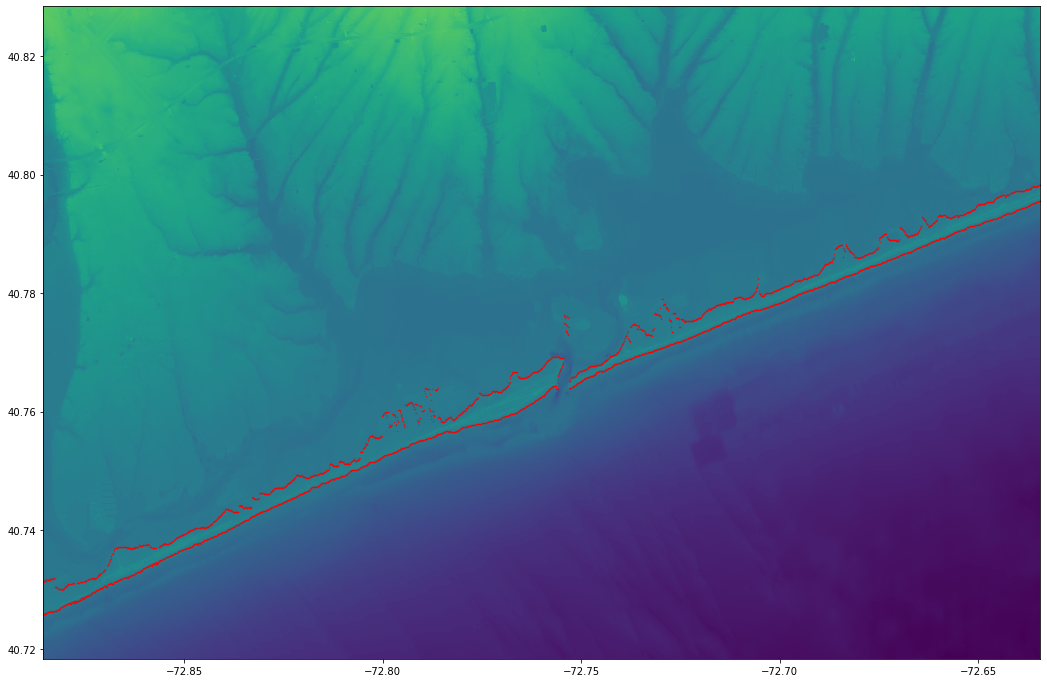

(1188, 2715)


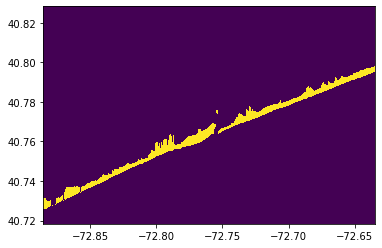

In [9]:

def find_points(topo_data):
    island_x = []
    points = []
    inds = []
    for i, lon in enumerate(topo_data.x):
        first_point = None
        row = np.array(topo_data.Z[:, i])
        not_land = np.where(row <= 0)
        land = np.where(row > 0)

        for point in land[0]:
            if topo_data.Z[point - 1, i] <= 0 and topo_data.Z[point, i] > 0:
                first_point = (point, topo_data.y[point], i, lon)
                break
        if first_point:
            for point in not_land[0]:
                if point > first_point[0] and topo_data.Z[point + 1, i] <= 0:
                    last_point = (point, topo_data.y[point], i, lon)
                    island_x.append((first_point, last_point))
                    break

    for p in island_x:
        inds.append([p[0][2], p[0][0], p[1][0]])
        for i in p:
            points.append([i[3], i[1]])

    return {
        "island_x": island_x,
        "inds": inds,
        "points": points,
    }

def find_inlet(topo_data):
    inlet_y = []
    points = []
    inds = []
    for i, lat in enumerate(topo_data.y):
        first_point = None
        row = np.array(topo_data.Z[i,:])
        not_land = np.where(row <= 0)
        land = np.where(row > 0)
        for point in land[0]:
            if topo_data.Z[i, point - 1] > 0 and topo_data.Z[i, point] <= 0:
                first_point = (point, topo_data.x[point], i, lat)
                # print(first_point)
                break
        if first_point:
            # print('first point')
            for point in not_land[0]:
                if point > first_point[0] and topo_data.Z[i, point + 1] <=0:
                    last_point = (point, topo_data.x[point], i, lat)
                    inlet_y.append((first_point, last_point))
                    break
    for p in inlet_y:
            inds.append([p[0][2], p[0][0], p[1][0]])
            for i in p:
                points.append([i[3], i[1]])
    return {
        'inlet_y': inlet_y,
        'inds': inds,
        'points':points}

island_coords = find_points(topo_data)
inlet_coords = find_inlet(topo_data)
island_x = island_coords["island_x"]
inds = island_coords["inds"]
points = island_coords["points"]

island_y = []

fig, ax = plt.subplots(1,figsize=(24,12))
plottools.pcolorcells(topo_data.X, topo_data.Y, topo_data.Z) #topo.z.plot.pcolormesh()
cax = plt.gca().set_aspect(1./np.cos(48*np.pi/180))
for pair in points:
    plt.scatter(pair[0], pair[1], c='r', s=0.1)
for pair in inlet_coords['points']:
    plt.scatter(pair[0], pair[1], c='k', s=0.1)

plt.show()

indices = []
for stuff in inds:
    for i in range(stuff[1], stuff[2]+1):
        indices.append((stuff[0], i))

mask_array = np.zeros(shape=topo_data.Z.shape)
print(mask_array.shape)
for locs in indices:
    col, row = locs
    mask_array[row, col] = 1

masks = np.ma.masked_array(topo_data.Z, np.logical_not(mask_array))
# topo.z.plot.pcolormesh()
plottools.pcolorcells(topo_data.X, topo_data.Y, mask_array)
cax = plt.gca().set_aspect(1./np.cos(48*np.pi/180))



In [11]:
inlet_coords['inlet_y']

[]

In [10]:
points = []
inds = []
for p in island_x:
#     print(p)
    inds.append([p[0][2],p[0][0], p[1][0]])
    for i in p:
#         print(i)
        points.append([i[3], i[1]])
#         inds.append([i[2],i[0]])

In [49]:
inds

[[0, 1339, 1378],
 [1, 1341, 1378],
 [2, 1340, 1378],
 [3, 1340, 1379],
 [4, 1340, 1380],
 [5, 1340, 1380],
 [6, 1340, 1380],
 [7, 1340, 1382],
 [8, 1341, 1382],
 [9, 1341, 1382],
 [10, 1341, 1383],
 [11, 1341, 1384],
 [12, 1341, 1384],
 [13, 1341, 1384],
 [14, 1341, 1384],
 [15, 1342, 1385],
 [16, 1342, 1386],
 [17, 1342, 1386],
 [18, 1342, 1386],
 [19, 1342, 1387],
 [20, 1343, 1388],
 [21, 1343, 1388],
 [22, 1343, 1389],
 [23, 1343, 1390],
 [24, 1343, 1390],
 [25, 1343, 1391],
 [26, 1343, 1391],
 [27, 1343, 1392],
 [28, 1344, 1392],
 [29, 1344, 1393],
 [30, 1344, 1393],
 [31, 1345, 1394],
 [32, 1345, 1394],
 [33, 1345, 1394],
 [34, 1345, 1394],
 [35, 1345, 1394],
 [36, 1345, 1395],
 [37, 1345, 1395],
 [38, 1345, 1396],
 [39, 1345, 1396],
 [40, 1345, 1396],
 [41, 1346, 1396],
 [42, 1346, 1396],
 [43, 1346, 1397],
 [44, 1347, 1398],
 [45, 1347, 1398],
 [46, 1347, 1398],
 [47, 1347, 1399],
 [48, 1347, 1399],
 [49, 1347, 1400],
 [50, 1347, 1400],
 [51, 1348, 1401],
 [52, 1348, 1402],
 [5

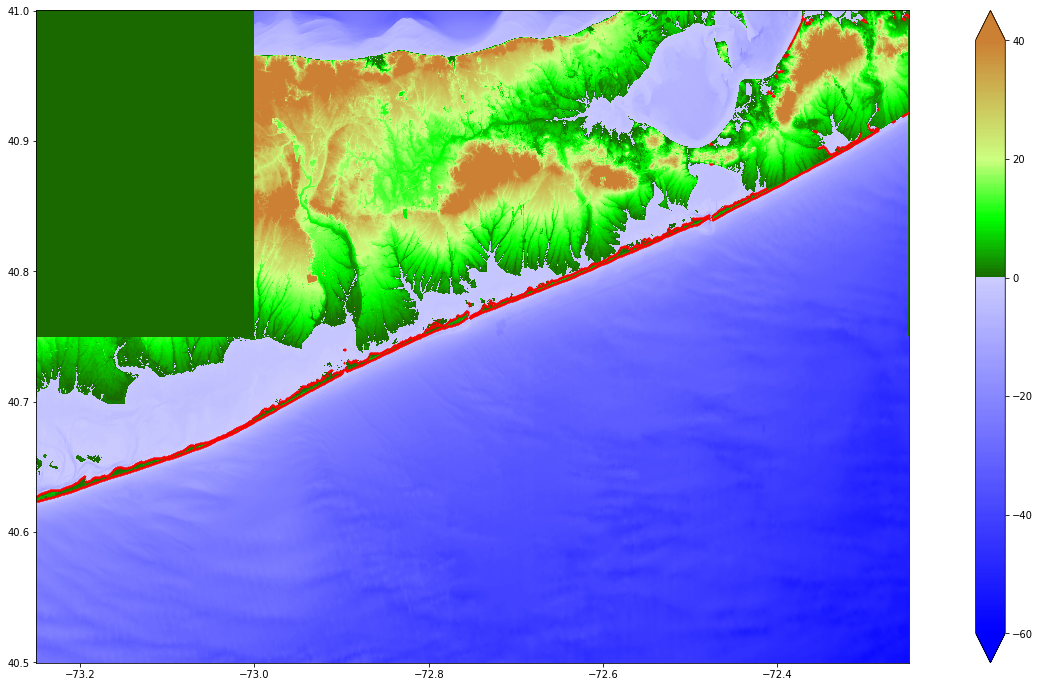

In [11]:
fig, ax = plt.subplots(1,figsize=(24,12))
plottools.pcolorcells(topo.X, topo.Y, topo.Z, cmap=cmap, norm=norm)
plt.colorbar(extend='both')
cax = plt.gca().set_aspect(1./np.cos(48*np.pi/180))
for pair in points: 
    plt.scatter(pair[0], pair[1], c='r', s=0.1)
plt.show()

In [12]:
indices = []
for stuff in inds:
    for i in range(stuff[1], stuff[2]+1):
        indices.append((stuff[0], i))

In [13]:
mask_array = np.zeros(shape=topo.Z.shape)
mask_array.shape

(5408, 10808)

In [14]:
for locs in indices:
    col, row = locs
    mask_array[row, col] = 1

In [46]:
# Zmasked = ma.masked_array(topo.Z, logical_not(pts_chosen))
masks = np.ma.masked_array(topo.Z, np.logical_not(mask_array))
# plt.plot(masks)

MaskError: Mask and data not compatible: data size is 58449664, mask size is 29743200.

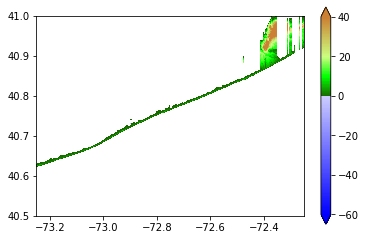

In [16]:
plottools.pcolorcells(topo.X, topo.Y, masks,cmap=cmap, norm=norm)
plt.colorbar(extend='both')
cax = plt.gca().set_aspect(1./np.cos(48*np.pi/180))

In [24]:
np.save('moriches_island.npy', topo.Z)
np.save('moriches_island_mask.npy', mask_array)

In [23]:
from mpl_toolkits import mplot3d

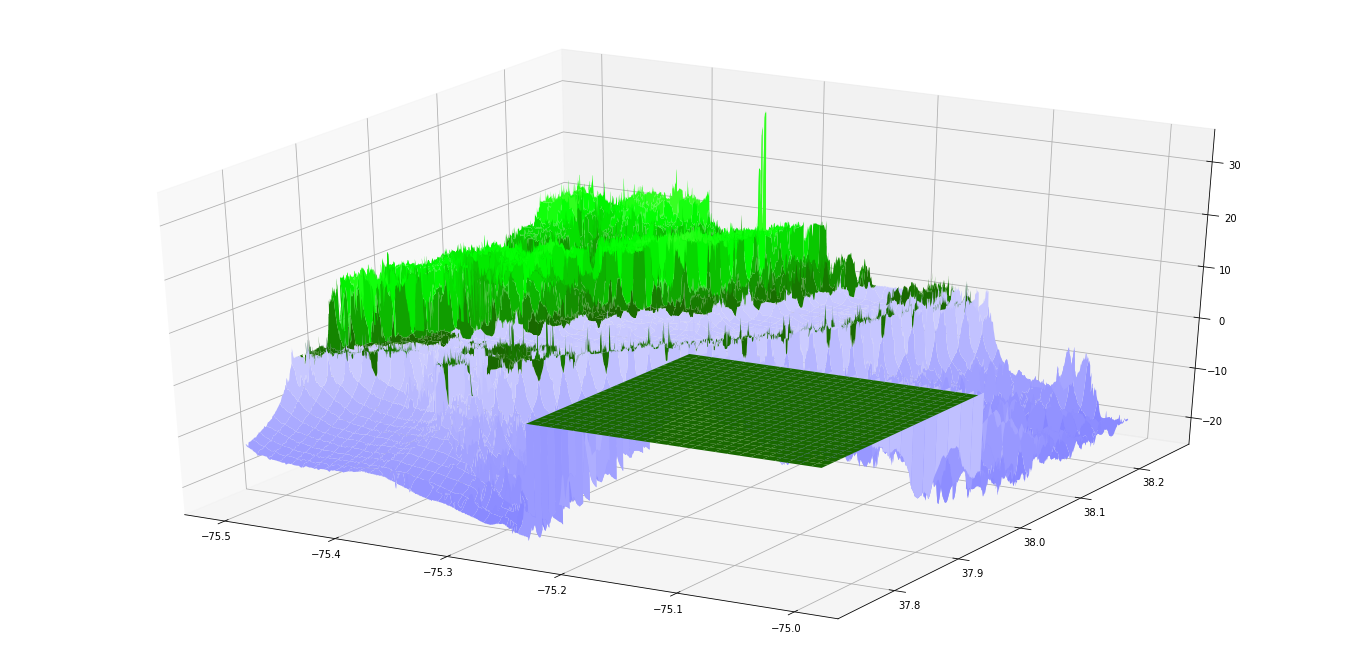

In [24]:
fig = plt.figure(figsize=(24,12))
ax = plt.axes(projection='3d')
ax.plot_surface(topo.X, topo.Y,masks, cmap=cmap, norm=norm)
# plt.gca().set_aspect(1./np.cos(48*np.pi/180))

In [17]:
from clawpack.amrclaw import region_tools
from clawpack.visclaw.plottools import pcolorcells
from pylab import *
from clawpack.geoclaw import topotools, dtopotools, kmltools, fgmax_tools, marching_front
from clawpack.visclaw import colormaps

In [78]:
rrect = region_tools.RuledRectangle()
rrect.ixy = 'x'
# mask_out = rrect.mask_outside(topo.X, topo.Y)

pts_chosen_Zabove0 = marching_front.select_by_flooding(topo_data.Z, mask=mask_array,
                                                      prev_pts_chosen=None,
                                                      Z1=0, Z2=5, max_iters=2)

pts_chosen_Zbelow0 = marching_front.select_by_flooding(topo_data.Z, mask=mask_array,
                                                     prev_pts_chosen=None,
                                                     Z1=0, Z2=-0.5,max_iters=None)

pts_chosen_Zbelow0 = marching_front.select_by_flooding(topo_data.Z, mask=mask_array,
                                                      prev_pts_chosen = pts_chosen_Zbelow0,
                                                      Z1 = 0, Z2 = -0.1, max_iters=10)

nearshore_pts = where(pts_chosen_Zabove0+pts_chosen_Zbelow0 == 2, 1, 0)
print(f'Number of nearshore points: {nearshore_pts.sum()}')

Selecting points with Z1 = 0, Z2 = 5, max_iters=2
Done after 2 iterations with 47888 points chosen
Selecting points with Z1 = 0, Z2 = -0.5, max_iters=29743200
Done after 20 iterations with 170933 points chosen
Selecting points with Z1 = 0, Z2 = -0.1, max_iters=10
Done after 1 iterations with 170933 points chosen
Number of nearshore points: 47888


In [56]:
pts_chosen = marching_front.select_by_flooding(mask_array, Z1=0, Z2=3, max_iters=None)

Selecting points with Z1 = 0, Z2 = 3, max_iters=29743200
Done after 1 iterations with 0 points chosen


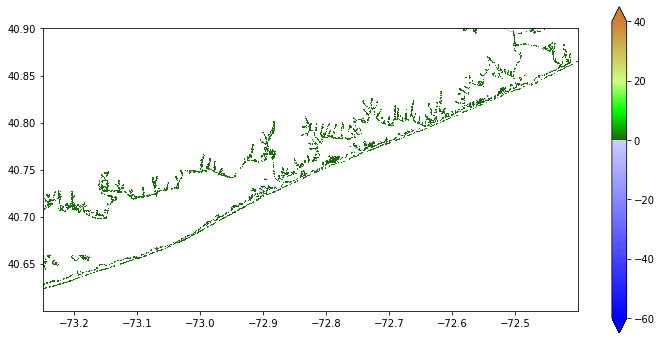

In [79]:
Zmasked = ma.masked_array(topo_data.Z, logical_not(nearshore_pts))

figure(figsize=(12,6))
pcolorcells(topo_data.X, topo_data.Y, Zmasked, cmap=cmap, norm=norm)
colorbar(extend='both')
gca().set_aspect(1./cos(48*pi/180.))

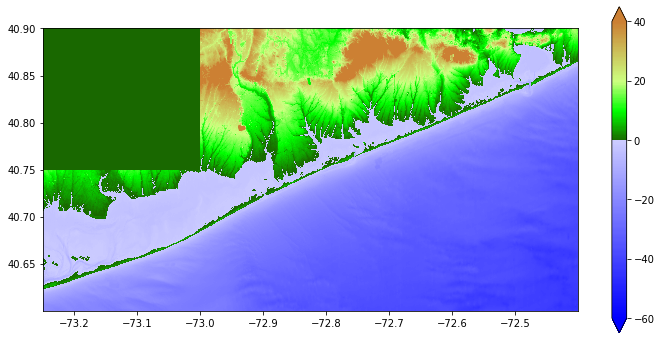

In [81]:
topo_no_island = ma.masked_array(topo_data.Z, logical_not(mask_array))
figure(figsize=(12,6))
pcolorcells(topo_data.X, topo_data.Y, topo_no_island, cmap=cmap, norm=norm)
colorbar(extend='both')
gca().set_aspect(1./cos(48*pi/180.))

In [82]:
topo_no_island

masked_array(
  data=[[-19.52474021911621, -19.439071655273438, -19.430068969726562,
         ..., -44.28327560424805, -44.31026840209961,
         -44.337989807128906],
        [-19.39653205871582, -19.3726863861084, -19.374340057373047, ...,
         -44.27802658081055, -44.30359649658203, -44.32989501953125],
        [-19.362346649169922, -19.34650421142578, -19.343996047973633,
         ..., -44.27265548706055, -44.29707717895508, -44.32219696044922],
        ...,
        [0.0, 0.0, 0.0, ..., 15.704690933227539, 15.621227264404297,
         15.564050674438477],
        [0.0, 0.0, 0.0, ..., 15.862504005432129, 15.76162052154541,
         15.482929229736328],
        [0.0, 0.0, 0.0, ..., 15.981724739074707, 15.883790969848633,
         15.624985694885254]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, Fals

In [77]:
rr3 = region_tools.ruledrectangle_covering_selected_points(topo_data.X, topo_data.Y, nearshore_pts, ixy='x', method=0,
                                                          verbose=True)
rr3.write('NY_shoreline.data')

Extending rectangles to cover grid cells
RuledRectangle covers 1826287 grid points


In [47]:
rr2 = region_tools.ruledrectangle_covering_selected_points(topo_data.X, topo_data.Y, mask_array, ixy='x', method=0,
                                                          verbose=True)

Extending rectangles to cover grid cells
RuledRectangle covers 363739 grid points


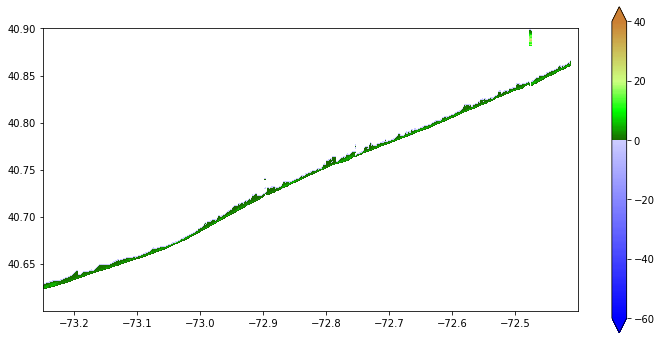

In [49]:
figure(figsize=(12,6))

Zmask = ma.masked_array(topo_data.Z, logical_not(mask_array))
pcolorcells(topo_data.X, topo_data.Y, Zmask, cmap=cmap, norm=norm)
colorbar(extend='both')
gca().set_aspect(1./cos(48*pi/180.))

In [50]:
rr2.write('NY_barrier_island.data')

In [73]:
mask_array

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])